In [1]:
# ECON662D1 Assignment 3 - Jean-Sébastien Matte 260913682

In [2]:
# import modules
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
import resample.bootstrap as rb
# np.random.seed(123)

In [3]:
# load data
in_dir = '/Users/jsmatte/github/ECON662D1/Assignment3'
in_file = str(in_dir + '/e662.as3.20.dat.txt')
df = pd.read_csv(in_file, sep = '\s+', header = None)
print(df)

           0          1          2          3
0  -0.429193   91.52508  -7.879150  -22.82027
1  -1.719862   58.32108 -10.377350  -46.89894
2  -5.007316   71.19264   8.240685  -83.72890
3  -0.287603   85.37536  -7.939428  -98.93214
4  -5.385808   84.63815  28.309510  -80.68243
..       ...        ...        ...        ...
95 -4.539189   26.54987 -40.947840 -146.96500
96 -9.798897   69.94029  75.729620 -126.41690
97 -2.504187   89.50351 -44.335000  -76.11952
98 -2.118638  100.67600  48.674720  -16.33207
99 -0.782366  133.57730   4.789128  -10.57532

[100 rows x 4 columns]


In [4]:
df.columns = ['y', 'x1', 'x2', 'x3']
print(df)

           y         x1         x2         x3
0  -0.429193   91.52508  -7.879150  -22.82027
1  -1.719862   58.32108 -10.377350  -46.89894
2  -5.007316   71.19264   8.240685  -83.72890
3  -0.287603   85.37536  -7.939428  -98.93214
4  -5.385808   84.63815  28.309510  -80.68243
..       ...        ...        ...        ...
95 -4.539189   26.54987 -40.947840 -146.96500
96 -9.798897   69.94029  75.729620 -126.41690
97 -2.504187   89.50351 -44.335000  -76.11952
98 -2.118638  100.67600  48.674720  -16.33207
99 -0.782366  133.57730   4.789128  -10.57532

[100 rows x 4 columns]


In [5]:
# create matrix X of the regressors (unrestricted model)
X = np.zeros((len(df),4))
for i in range(X.shape[0]):
    X[i] = [1, df.x1.values[i], df.x2.values[i], df.x3.values[i]]
print(X.shape)

# # create matrix X of the regressors (restricted model)
# X_restrict = np.zeros((len(df),3))
# for i in range(X_restrict.shape[0]):
#     X_restrict[i] = [1, df.x2.values[i], df.x3.values[i]]
# print(X.shape)

# create vector y of observations
y = np.array([[j] for j in df.y.values])
print(y.shape)

(100, 4)
(100, 1)


In [6]:
# Create the different OLS models of different sample sizes
n = 17
H1 = []
H2 = []
for i in range(n):
    print('MODEL_' + str(i))
    
    # unrestricted model
    globals()['model_' + str(i)] = sm.OLS(y[0:(20+5*i), :], X[0:(20+5*i), :]).fit()
    temp_reg = globals()['model_' + str(i)]
#     print(temp_reg.summary)
#     print('')
    
    # Residuals
    temp_resid = temp_reg.resid
   
    # Hypothesis 1: H0: B1 = 0
    print('Hopothesis 1: H0: B1 = 0')
    temp_P_H1 = []
    
    # restricted model
    X_rest0 = X[0:(20+5*i), [0, 2, 3]]
    globals()['model_' + str(i) + '_rest0'] = sm.OLS(y[0:(20+5*i), :], X_rest0).fit()
    temp_reg_rest0 = globals()['model_' + str(i) + '_rest0']
    
    # restricted residuals
    temp_resid_rest0 = temp_reg_rest0.resid
    
    # P-value based on Student t-test
    print('P-value based on Student t-test')
    print(temp_reg.t_test('x1 = 0'))
    print(temp_reg.t_test('x1 = 0').pvalue)
    temp_P_H1.append(temp_reg.pvalues[1])
    print('')
    
    
    # P-value from rescaled restricted residuals bootstrap
    temp_nobs = temp_reg.nobs
    
    # rescale residuals
    rescale_factor = np.sqrt(temp_nobs / (temp_nobs - 4))
#     temp_resid = temp_reg.resid
#     rescaled_temp_resid = rescale_factor * temp_resid
    rescaled_temp_resid = rescale_factor * temp_resid_rest0
    
    temp_params = temp_reg.params
    B1_list = []
    for b in range(999):
        # draw from distrubances
        draws = np.random.choice(rescaled_temp_resid, size = len(rescaled_temp_resid))  # replace = True, 

        # update observations using rescaled, restricted, resampled residuals
        temp_y_star = temp_reg.fittedvalues + draws
        temp_y_star = np.array([[j] for j in temp_y_star])

        # rerun regression
        temp_reg_star = sm.OLS(temp_y_star, X[0:(20+5*i), :]).fit()

        # get new model B1 parameter
        B1_list.append(temp_reg_star.params[1])
    
    B1_mean = np.mean(B1_list)
    B1_std = np.std(B1_list)
    print('Bootstrap mean for B1: ', B1_mean)
    print('Bootstrap std for B1: ', B1_std)
    boot_t_stat = np.mean(B1_list) / np.std(B1_list)
    boot_pvalue = sp.stats.t.sf(abs(boot_t_stat), temp_nobs - 3)*2
    print('Bootstrap t-statistic for B1: ', boot_t_stat)
    print('Bootstrap p-value for B1: ', boot_pvalue)
#     print('P-value from rescaled restricted residuals bootstrap')
#     print(boot_pvalue)
    temp_P_H1.append(boot_pvalue)
    print('')
    
    
    # P-value from wild bootstrap
    # define the pmf of s* as proposed by Mammen
    xk = [-1, 1]  # -> the rv_discrete class is only defined for xk values that are integers, thus we define the 
                  #    pmf as such. after random draws, we reassign the correct values to the s* vector and carry on
                  #    with our computation
    pk = [((np.sqrt(5)+1) / (2*np.sqrt(5))), ((np.sqrt(5)-1) / (2*np.sqrt(5)))]
    s_pmf = sp.stats.rv_discrete(name = 's_pmf', values = (xk, pk))
    
#     # define the pmf of s* as proposed by Rademacher
#     xk_Rad = [-1, 1]
#     pk_Rad = [0.5, 0.5]
#     s_pmf_Rad = sp.stats.rv_discrete(name = 's_pmf_Rad', values = (xk_Rad, pk_Rad))
    
    # get s_star
    s_star_raw = s_pmf.rvs(size = len(temp_resid))
    
    s_star = []
    for s in s_star_raw:
        if s == -1:
            s_star.append(-(np.sqrt(5) - 1) / 2)
        elif s == 1:
            s_star.append((np.sqrt(5) + 1) / 2)
    
    # update observations using wild disturbances
    temp_y_star_wild = temp_reg.fittedvalues + s_star
    temp_y_star_wild = np.array([[q] for q in temp_y_star_wild])
    
    # rerun regression
    temp_reg_wild = sm.OLS(temp_y_star_wild, X[0:(20+5*i), :]).fit()

    # get new model parameters and regression summary
    temp_param_wild = temp_reg_wild.params
#     print(temp_reg_wild.summary())
    print('P-value from wild bootstrap')
    print(temp_reg_wild.t_test('x1 = 0'))
    print(temp_reg_wild.t_test('x1 = 0').pvalue)
    temp_P_H1.append(temp_reg_wild.t_test('x1 = 0').pvalue)
    print('')
    
    H1.append(temp_P_H1)
    
    
    # Hypothesis 1: H0: B1 = 0.1
    print('Hopothesis 2: H0: B1 = 0.1')
    temp_P_H2 = []
    
    # P-value based on Student t-test
    print('P-value based on Student t-test')
    print(temp_reg.t_test('x1 = 0.1'))
    print(temp_reg.t_test('x1 = 0.1').pvalue)
    temp_P_H2.append(temp_reg.t_test('x1 = 0.1').pvalue)
    print('')
    
    # P-value from rescaled restricted residuals bootstrap
    boot_t_stat2 = (np.mean(B1_list) - 0.1) / np.std(B1_list)
    boot_pvalue2 = sp.stats.t.sf(abs(boot_t_stat2), temp_nobs - 3)*2
    print('Bootstrap t-statistic for B1: ', boot_t_stat2)
    print('Bootstrap p-value for B1: ', boot_pvalue2)
#     print('P-value from rescaled restricted residuals bootstrap')
#     print(boot_pvalue2)
    temp_P_H2.append(boot_pvalue2)
    print('')
    
    
    # P-value from wild bootstrap
    print('P-value from wild bootstrap')
    print(temp_reg_wild.t_test('x1 = 0.1'))
    print(temp_reg_wild.t_test('x1 = 0.1').pvalue)
    temp_P_H2.append(temp_reg_wild.t_test('x1 = 0.1').pvalue)
    print('')
    
    H2.append(temp_P_H2)
    
    print('-------------------------------------------------------')
    print('')

MODEL_0
Hopothesis 1: H0: B1 = 0
P-value based on Student t-test
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0056      0.015      0.366      0.719      -0.027       0.038
0.7191648727895874

Bootstrap mean for B1:  0.00537721438499595
Bootstrap std for B1:  0.014651164212235229
Bootstrap t-statistic for B1:  0.36701618431833716
Bootstrap p-value for B1:  0.7181355775093663

P-value from wild bootstrap
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0091      0.012      0.779      0.448      -0.016       0.034
0.44762760269285073

Hopothesis 2: H0: B1 = 0.1
P-value based on Stud

Bootstrap mean for B1:  0.007802819442129003
Bootstrap std for B1:  0.010264543034818049
Bootstrap t-statistic for B1:  0.7601721202455183
Bootstrap p-value for B1:  0.45196867434350774

P-value from wild bootstrap
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0016      0.009      0.186      0.853      -0.016       0.020
0.8532437241826611

Hopothesis 2: H0: B1 = 0.1
P-value based on Student t-test
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0080      0.010     -8.925      0.000      -0.013       0.029
1.181993501685605e-10

Bootstrap t-statistic for B1:  -8.982102782864441
B

Bootstrap mean for B1:  0.0043977838823182815
Bootstrap std for B1:  0.007789779572712886
Bootstrap t-statistic for B1:  0.5645581933696102
Bootstrap p-value for B1:  0.5745893743183004

P-value from wild bootstrap
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0052      0.006      0.927      0.358      -0.006       0.016
0.35789633073821503

Hopothesis 2: H0: B1 = 0.1
P-value based on Student t-test
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0048      0.008    -12.341      0.000      -0.011       0.020
1.3106722086846295e-17

Bootstrap t-statistic for B1:  -12.27277552917804

Bootstrap mean for B1:  0.005806602391986733
Bootstrap std for B1:  0.0058582427458442965
Bootstrap t-statistic for B1:  0.9911850095501427
Bootstrap p-value for B1:  0.3246998294545661

P-value from wild bootstrap
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0068      0.006      1.177      0.243      -0.005       0.018
0.242918096848262

Hopothesis 2: H0: B1 = 0.1
P-value based on Student t-test
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0056      0.006    -15.794      0.000      -0.006       0.018
1.0293753404586424e-25

Bootstrap t-statistic for B1:  -16.07878022378501
B

Bootstrap mean for B1:  0.00629243081638378
Bootstrap std for B1:  0.00508492785462623
Bootstrap t-statistic for B1:  1.2374670784481183
Bootstrap p-value for B1:  0.21890091810556128

P-value from wild bootstrap
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0061      0.005      1.210      0.229      -0.004       0.016
0.22914259592259795

Hopothesis 2: H0: B1 = 0.1
P-value based on Student t-test
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0063      0.005    -18.404      0.000      -0.004       0.016
3.0020740148204965e-33

Bootstrap t-statistic for B1:  -18.428495322379405


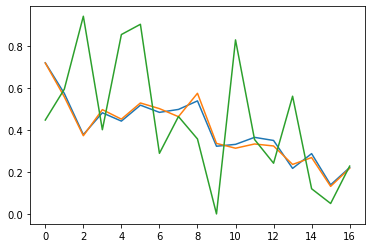

In [7]:
H11 = []
H12 = []
H13 = []
for H in H1:
    H11.append(H[0])
    H12.append(H[1])
    H13.append(H[2])
    
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(H11)
plt.plot(H12)
plt.plot(H13)
plt.show()

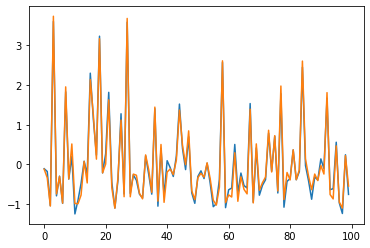

In [8]:
resid_16 = model_16.resid
resid_rest0_16 = model_16_rest0.resid
x = np.arange(len(resid_16))
import matplotlib.pyplot as plt
%matplotlib inline
# plt.scatter(x, resid_16)
plt.plot(resid_16)
plt.plot(resid_rest0_16)
plt.show()

In [9]:
print(model_0.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     6.351
Date:                Fri, 27 Nov 2020   Prob (F-statistic):            0.00485
Time:                        14:26:30   Log-Likelihood:                -34.074
No. Observations:                  20   AIC:                             76.15
Df Residuals:                      16   BIC:                             80.13
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6174      1.558     -0.396      0.6

In [10]:
# Test --- Test --- Test --- Test --- Test --- Test --- Test --- Test
for i1 in [0]:
    print(globals()['model_' + str(i1)].summary())
    print('')
#     print(globals()['model_' + str(i1)].pvalues)
#     print('')
    
    # Hypothesis 1: H0: B1 = 0
    # P-value based on Student t-test
    print(globals()['model_' + str(i1)].t_test('x1 = 0'))
    print(globals()['model_' + str(i1)].t_test('x1 = 0.1'))
    print('')
#     print(globals()['model_' + str(i1)].t_test('x1 = 0').pvalue)
#     print('')

    # P-value from rescaled restricted residuals bootstrap
    temp_nobs = globals()['model_' + str(i1)].nobs
    rescale_factor = np.sqrt(temp_nobs / (temp_nobs - 4))
    
    
    temp_params = globals()['model_' + str(i1)].params
    temp_resid = globals()['model_' + str(i1)].resid
    reg_star = globals()['model_' + str(i1)]
    B1_list = []
    for b in range(999):
        # rescale residuals
        rescaled_temp_resid = rescale_factor * temp_resid
        
        # draw from distrubances
        draw = np.random.choice(rescaled_temp_resid, size = len(rescaled_temp_resid))  # replace = True, 

        # update observations using rescaled, resampled disturbances
        temp_y_star = np.matmul(X[0:(20+5*i1), :], temp_params.T) + draw
#         temp_y_star_test = reg_star.fittedvalues + draw
        temp_y_star = np.array([[j] for j in temp_y_star])

        # rerun regression
        temp_reg = sm.OLS(temp_y_star, X[0:(20+5*i1), :]).fit()

        # get new model parameters and residuals
        B1_list.append(temp_reg.params[1])
#         temp_param = temp_reg.params
#         temp_resid = temp_reg.resid
#         reg_star = temp_reg
        
#     print(reg_star.summary())
#     print(reg_star.t_test('x1 = 0'))
#     print(reg_star.t_test('x1 = 0.1'))
    B1_mean = np.mean(B1_list)
    B1_std = np.std(B1_list)
    print(B1_mean, B1_std)
    boot_t_stat = np.mean(B1_list) / np.std(B1_list)
    boot_pvalue = sp.stats.t.sf(boot_t_stat, temp_nobs - 3)*2
    print(boot_t_stat)
    print(boot_pvalue)
#     boot_stat1, boot_pvalue1 = sp.stats.ttest_1samp(B1_list, 0)
#     print(boot_stat1, boot_pvalue1)
    print('')
    
    # P-value from wild bootstrap
    temp_resid_wild = globals()['model_' + str(i1)].resid
    
    # define the pmf of s*
    xk = [-1, 1]  # -> the rv_discrete class is only defined for xk values that are integers, thus we define the 
                  #    pmf as such. after random draws, we reassign the correct values to the s* vector and carry on
                  #    with our computation
    pk = [((np.sqrt(5)+1) / (2*np.sqrt(5))), ((np.sqrt(5)-1) / (2*np.sqrt(5)))]
    s_pmf = sp.stats.rv_discrete(name = 's_pmf', values = (xk, pk))
    
#     import matplotlib.pyplot as plt
#     %matplotlib inline
#     fig, ax = plt.subplots(1, 1)
#     ax.plot(xk, s_pmf.pmf(xk), 'ro', ms=12, mec='r')
#     ax.vlines(xk, 0, s_pmf.pmf(xk), colors='r', lw=4)
#     plt.show()
    
    # get s_star
    s_star_raw = s_pmf.rvs(size = len(temp_resid_wild))
#     print(s_star_raw)
    
    s_star = []
    for s in s_star_raw:
        if s == -1:
            s_star.append(-(np.sqrt(5) - 1) / 2)
        elif s == 1:
            s_star.append((np.sqrt(5) + 1) / 2)
#     print(s_star)
    
    # update observations using wild disturbances
    temp_y_star_wild = np.matmul(X[0:(20+5*i1), :], temp_params.T) + s_star
    temp_y_star_wild = np.array([[j] for j in temp_y_star_wild])
    
    # rerun regression
    temp_reg_wild = sm.OLS(temp_y_star_wild, X[0:(20+5*i1), :]).fit()

    # get new model parameters and regression summary
    temp_param_wild = temp_reg_wild.params
    print(temp_reg_wild.summary())
    print(temp_reg_wild.t_test('x1 = 0'))
    print(temp_reg_wild.t_test('x1 = 0.1'))

    

    
    
    
    # Hypothesis 2: H0: B1 = 0.1
#     print(globals()['model_' + str(i1)].t_test('x1 = 0.1'))
#     print('')
#     print(globals()['model_' + str(i1)].t_test('x1 = 0.1').pvalue)
#     print('')
    
    print('-----------------------------------')
    print('')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     6.351
Date:                Fri, 27 Nov 2020   Prob (F-statistic):            0.00485
Time:                        14:26:50   Log-Likelihood:                -34.074
No. Observations:                  20   AIC:                             76.15
Df Residuals:                      16   BIC:                             80.13
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6174      1.558     -0.396      0.6

7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.74380559

7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.743805596760466e-16
7.74380559